<a href="https://colab.research.google.com/github/simjeongho/XceptionV2/blob/main/AddInceptionXceptionGreat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import warnings

In [2]:
#import necessary libraries

import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,Conv2D,Add
from tensorflow.keras.layers import SeparableConv2D,ReLU, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization,MaxPool2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, AveragePooling2D
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras.layers import Concatenate

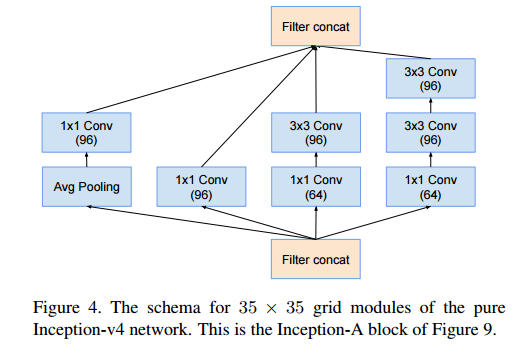

In [3]:
def inception_A_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_3x3x3_reduce, filters_3x3x3, filters_avg_pool,
                      name=None, strides=1):
    '''
    x: 입력 Tensor
    filters_1x1: 단독 1x1 필터수
    filters_3x3_reduce: 3x3 Conv 적용 전 1x1 Conv 필터수
    filters_3x3: 3x3 Conv 필터수
    filters_3x3x3_reduce: 3x3x3 Conv 적용 전 1x1 Conv 필터수
    filters_3x3x3: 3x3x3 Conv 필터수
    filters_avg_pool : global average pooling 이 후 1x1필터 수 
    
    '''
    
    # 첫번째 1x1 Conv
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', strides=strides)(x)

    # 3x3 적용 전 1x1 conv -> 3x3 Conv
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu',strides=strides)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu',strides=1)(conv_3x3)

    # 3x3, 3x3 적용 전 1x1 Conv -> 3x3 Conv
    conv_3x3x3 = Conv2D(filters_3x3x3_reduce, (1, 1), padding='same', activation='relu',strides=strides)(x)
    conv_3x3x3 = Conv2D(filters_3x3x3, (3, 3), padding='same', activation='relu',strides=1)(conv_3x3x3)
    conv_3x3x3 = Conv2D(filters_3x3x3, (3, 3), padding='same', activation='relu',strides=1)(conv_3x3x3)

    avg_pool = AveragePooling2D(padding="same", pool_size=3, strides=strides)(x)
    avg_pool = Conv2D(filters_avg_pool, (1, 1), padding='same', activation='relu',strides=1)(avg_pool)
    # 단독 1x1 결과, 3x3 결과, 3x3x3 결과, AvgPool이후 1x1 결과 feature map을 채널 기준으로 Concat 적용. 
    output = Concatenate(axis=-1, name=name)([conv_1x1, conv_3x3, conv_3x3x3, avg_pool])
    return output

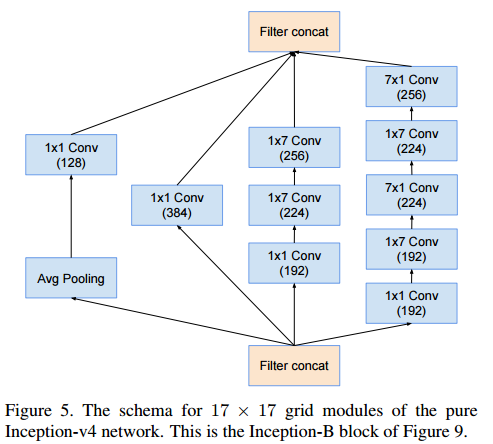

In [4]:
def inception_B_module(x, filters_1x1, filters_2_7x7_reduce, filters_2_1x7, filters_2_7x1,filters_3_7x1x1x7_reduce, filters_3_1x7_1,filters_3_7x1_2, filters_3_1x7_3, filters_3_7x1_4, 
                     filters_avg_pool, name=None, strides=1):
    '''
    x: 입력 Tensor
    filters_1x1: 단독 1x1 필터수
    filters_7x7_reduce: 1x7 1x7 Conv 적용 전 1x1 Conv 필터수
    
    '''
    
    # 첫번째 1x1 Conv
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', strides=strides)(x)
    # 7x7 적용 전 1x1 conv -> 7x7 Conv
    conv_7x7 = Conv2D(filters_2_7x7_reduce, (1, 1), padding='same', activation='relu',strides=strides)(x)
    conv_7x7 = Conv2D(filters_2_1x7, (1, 7), padding='same', activation='relu',strides=1)(conv_7x7)
    conv_7x7 = Conv2D(filters_2_7x1, (1, 7), padding='same', activation='relu',strides=1)(conv_7x7)

    # 7x7x7, 7x7x7 적용 전 1x1 Conv -> 7x7x7 Conv
    conv_7x7x7 = Conv2D(filters_3_7x1x1x7_reduce, (1, 1), padding='same', activation='relu',strides=strides)(x)
    conv_7x7x7 = Conv2D(filters_3_1x7_1, (1, 7), padding='same', activation='relu',strides=1)(conv_7x7x7)
    conv_7x7x7 = Conv2D(filters_3_7x1_2, (7, 1), padding='same', activation='relu',strides=1)(conv_7x7x7)
    conv_7x7x7 = Conv2D(filters_3_1x7_3, (1, 7), padding='same', activation='relu',strides=1)(conv_7x7x7)
    conv_7x7x7 = Conv2D(filters_3_7x1_4, (7, 1), padding='same', activation='relu',strides=1)(conv_7x7x7)

    # Average pooling 부분 
    avg_pool = AveragePooling2D(padding="same", pool_size=3, strides=strides )(x)
    avg_pool = Conv2D(filters_avg_pool, (1, 1), padding='same', activation='relu',strides=1)(avg_pool)
    # 단독 1x1 결과, 3x3 결과, 5x5 결과, pool이후 1x1 결과 feature map을 채널 기준으로 Concat 적용. 
    output = Concatenate(axis=-1, name=name)([conv_1x1, conv_7x7, conv_7x7x7, avg_pool])
    return output

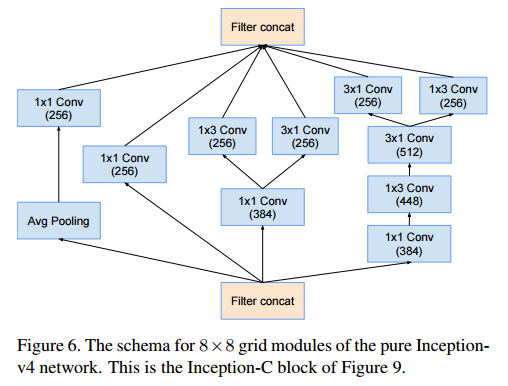

In [5]:
def inception_C_module(x, filters_1x1, filters_2_3x11x3_reduce, filters_2_1x3, filters_2_3x1,filters_3_3x11x3_reduce, filters_3_1x3_1,filters_3_3x1_2, filters_3_1x3_3, filters_3_3x1_4, 
                     filters_avg_pool, name=None, strides=1):
    
    # 첫번째 1x1 Conv
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu',strides=strides)(x)

    # 3x1 1x3 적용 전 1x1 conv -> 3x1 1x3 분기 Conv
    conv_3x11x3 = Conv2D(filters_2_3x11x3_reduce, (1, 1), padding='same', activation='relu',strides=strides)(x)
    conv_3x11x3_1 = Conv2D(filters_2_1x3, (1, 3), padding='same', activation='relu',strides=1)(conv_3x11x3)
    conv_3x11x3_2 = Conv2D(filters_2_3x1, (3, 1), padding='same', activation='relu',strides=1)(conv_3x11x3)
    #conv_3x11x3_3 = Concatenate(axis=-1, name=name)([conv_3x11x3_1, conv_3x11x3_2])

    # 1x3 3x1 1x3 3x1  적용 전 1x1 Conv -> 1x3 3x1 하고 분기 conv
    conv_3x11x3x2 = Conv2D(filters_3_3x11x3_reduce, (1, 1), padding='same', activation='relu',strides=strides)(x)
    conv_3x11x3x2 = Conv2D(filters_3_1x3_1, (1, 3), padding='same', activation='relu',strides=1)(conv_3x11x3x2)
    conv_3x11x3x2 = Conv2D(filters_3_3x1_2, (3, 1), padding='same', activation='relu',strides=1)(conv_3x11x3x2)
    conv_3x11x3x2_1 = Conv2D(filters_3_1x3_3, (1, 3), padding='same', activation='relu',strides=1)(conv_3x11x3x2)
    conv_3x11x3x2_2 = Conv2D(filters_3_3x1_4, (3, 1), padding='same', activation='relu',strides=1)(conv_3x11x3x2)
    #conv_3x11x3x2_3 = Concatenate(axis=-1, name=name)([conv_3x11x3x2_1, conv_3x11x3x2_2])

    # Global Average pooling 부분 
    avg_pool = AveragePooling2D(padding="same", pool_size=3, strides=strides)(x)
    avg_pool = Conv2D(filters_avg_pool, (1, 1), padding='same', activation='relu',strides=1)(avg_pool)
    # 단독 1x1 결과, 3x3 결과, 5x5 결과, pool이후 1x1 결과 feature map을 채널 기준으로 Concat 적용. 
    output = Concatenate(axis=-1, name=name)([conv_1x1, conv_3x11x3_1, conv_3x11x3_2, conv_3x11x3x2_1,conv_3x11x3x2_2, avg_pool])
    return output

In [6]:
#convolution 연산을 수행하는 함수 BatchNormalization 까지 수행한다. 

def conv_bn(x, filters, kernel_size, strides=1):
    
    x = Conv2D(filters=filters, 
               kernel_size = kernel_size, 
               strides=strides, 
               padding = 'same', 
               use_bias = False)(x)
    x = BatchNormalization()(x)
    return x

In [7]:
# def sep_bn(x, filters, kernel_size, strides=1):
    
#     x = DepthwiseConv2D( 
#                         kernel_size = (3,1), 
#                         strides=strides, 
#                         padding = 'same', 
#                         use_bias = False)(x)
#     x = DepthwiseConv2D(
#                         kernel_size = (1, 3), 
#                         strides=strides, 
#                         padding = 'same', 
#                         use_bias = False)(x)
    
#     x = Conv2D(filters=filters, 
#                kernel_size=(1,1), 
#                strides=strides,padding='same', 
#                use_bias='false')(x)

#     x = BatchNormalization()(x)
#     return x

#Separable Convolution을 수행하는 함수에 해당한다. 

def sep_bn(x, filters, kernel_size, strides=1):
    
    x = SeparableConv2D(filters=filters, 
                        kernel_size = kernel_size, 
                        strides=strides, 
                        padding = 'same', 
                        use_bias = False)(x)
    x = BatchNormalization()(x)
    return x

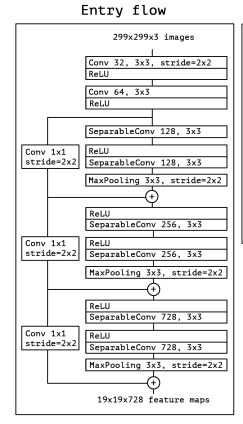

In [8]:
#entry Flow ReLu()함수는 따로 수행해주었다. 


def entry_flow(x):
    
    #feature map 절반으로 줄음 strides=2 때문
    x = conv_bn(x, filters =32, kernel_size =3, strides=2)
    x = ReLU()(x)
    x = conv_bn(x, filters =64, kernel_size =3, strides=1)
    tensor = ReLU()(x)
    
    x = sep_bn(tensor, filters = 128, kernel_size =3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 128, kernel_size =3)
    #feature map 크기 줄어들음 strides=2
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    #feature map 56
    tensor = conv_bn(tensor, filters=128, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    #x = inception_A_module(x, filters_1x1=256, filters_3x3_reduce=128, filters_3x3=96, filters_3x3x3_reduce=128, filters_3x3x3=96, filters_avg_pool=96)
    x = ReLU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = inception_A_module(tensor, filters_1x1=64, filters_3x3_reduce=128, 
                                filters_3x3=64, filters_3x3x3_reduce=128, filters_3x3x3=64, 
                               filters_avg_pool=64, strides=2)
    #tensor = conv_bn(tensor, filters=256, kernel_size = 1,strides=2)
    #Add는 차원까지 같아야함 
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    #tensor = conv_bn(tensor, filters=728, kernel_size = 1,strides=2)
    tensor = inception_B_module(tensor, filters_1x1=182, filters_2_7x7_reduce=128, filters_2_1x7=128, filters_2_7x1=182,filters_3_7x1x1x7_reduce=128, filters_3_1x7_1=128,filters_3_7x1_2=128, filters_3_1x7_3=128, filters_3_7x1_4=182, 
                     filters_avg_pool=182, name=None, strides=2)
    x = Add()([tensor,x])
    return x

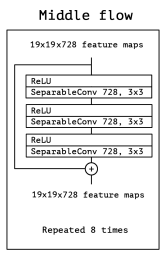

In [9]:
# middle flow

def middle_flow(tensor):
    
    for _ in range(8):
        x = ReLU()(tensor)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        #x = inception_C_module(x, filters_1x1=256, filters_2_3x11x3_reduce=384, filters_2_1x3=256, filters_2_3x1=256,filters_3_3x11x3_reduce=384, filters_3_1x3_1=448,filters_3_3x1_2=512, filters_3_1x3_3=256, filters_3_3x1_4=256, 
                     #filters_avg_pool=256, name=None)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        #tensor = inception_B_module(tensor, filters_1x1=182, filters_2_7x7_reduce=128, filters_2_1x7=128, filters_2_7x1=182,filters_3_7x1x1x7_reduce=128, filters_3_1x7_1=128,filters_3_7x1_2=128, filters_3_1x7_3=128, filters_3_7x1_4=182, 
                     #filters_avg_pool=182, name=None, strides=1)
        tensor = Add()([tensor,x])
        
    return tensor

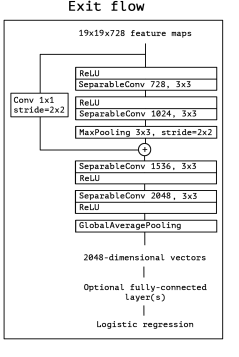

In [10]:
# exit flow

def exit_flow(tensor, n_classes):
    
    x = ReLU()(tensor)
    x = sep_bn(x, filters = 728,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 1024,  kernel_size=3)
    x = MaxPool2D(pool_size = 3, strides = 2, padding ='same')(x)
    
    tensor = conv_bn(tensor, filters =1024, kernel_size=1, strides =2)
    # tensor = inception_C_module(tensor, filters_1x1=256, filters_2_3x11x3_reduce=384, filters_2_1x3=256, filters_2_3x1=256,filters_3_3x11x3_reduce=384, filters_3_1x3_1=448,filters_3_3x1_2=512, filters_3_1x3_3=256, filters_3_3x1_4=256, 
    #                  filters_avg_pool=256, name=None, strides=2)
    x = Add()([tensor,x])
    
    x = sep_bn(x, filters = 1536,  kernel_size=3)
    x = ReLU()(x)
    tensor = inception_C_module(tensor, filters_1x1=256, filters_2_3x11x3_reduce=384, filters_2_1x3=256, filters_2_3x1=256,filters_3_3x11x3_reduce=384, filters_3_1x3_1=448,filters_3_3x1_2=512, filters_3_1x3_3=256, filters_3_3x1_4=256, 
                      filters_avg_pool=256, name=None, strides=1)
    x = Add()([tensor,x])
    x = sep_bn(x, filters = 2048,  kernel_size=3)
    x = GlobalAveragePooling2D()(x)
    
    x = Dense (n_classes, activation = 'softmax')(x)
    
    return x

In [11]:
def create_Xception(in_shape=(224,224,3), n_classes=10):
  input_tensor = Input(shape=in_shape)
  x = entry_flow(input_tensor)
  x = middle_flow(x)
  output = exit_flow(x, n_classes)# Entry Flow에 Dense layer가 있기 때문에 n_classes를 정해줘야한다. 

  model = Model(inputs=input_tensor, outputs=output)

  return model

In [12]:
xception = create_Xception(in_shape=(224,224,3), n_classes=10)

xception.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [13]:
IMAGE_SIZE = 128
BATCH_SIZE = 64

In [14]:
import random as python_random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import Sequence
import cv2
import sklearn

# 픽셀 값 계산 
def zero_one_scaler(image):
    return image/255.0

def get_preprocessed_ohe(images, labels, pre_func=None):
    # preprocessing 함수가 입력되면 이를 이용하여 image array를 scaling 적용.
    if pre_func is not None:
        images = pre_func(images)
    # OHE 적용    
    oh_labels = to_categorical(labels)
    return images, oh_labels

# 학습/검증/테스트 데이터 세트에 전처리 및 OHE 적용한 뒤 반환 
def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021):
    # 학습 및 테스트 데이터 세트를  0 ~ 1사이값 float32로 변경 및 OHE 적용. 
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)
    
    # 학습 데이터를 검증 데이터 세트로 다시 분리
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)
    
    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels )

from tensorflow.keras.utils import Sequence
import cv2
import sklearn

# 입력 인자 images_array labels는 모두 numpy array로 들어옴. 
# 인자로 입력되는 images_array는 전체 32x32 image array임. 
class CIFAR_Dataset(Sequence):
    def __init__(self, images_array, labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=False, pre_func=None):
        '''
        파라미터 설명
        images_array: 원본 32x32 만큼의 image 배열값 - cifar10은 32x32이기 때문에 . 
        labels: 해당 image의 label들
        batch_size: __getitem__(self, index) 호출 시 마다 가져올 데이터 batch 건수
        augmentor: albumentations 객체
        shuffle: 학습 데이터의 경우 epoch 종료시마다 데이터를 섞을지 여부
        '''
        # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당. 
        # 인자로 입력되는 images_array는 전체 32x32 image array임.
        self.images_array = images_array
        self.labels = labels
        self.batch_size = batch_size
        self.augmentor = augmentor
        self.pre_func = pre_func
        # train data의 경우 
        self.shuffle = shuffle
        if self.shuffle:
            # 객체 생성시에 한번 데이터를 섞음. 
            #self.on_epoch_end()
            pass
    
    # Sequence를 상속받은 Dataset은 batch_size 단위로 입력된 데이터를 처리함. 
    # __len__()은 전체 데이터 건수가 주어졌을 때 batch_size단위로 몇번 데이터를 반환하는지 나타남
    def __len__(self):
        # batch_size단위로 데이터를 몇번 가져와야하는지 계산하기 위해 전체 데이터 건수를 batch_size로 나누되, 정수로 정확히 나눠지지 않을 경우 1회를 더한다. 
        return int(np.ceil(len(self.labels) / self.batch_size))
    
    # batch_size 단위로 image_array, label_array 데이터를 가져와서 변환한 뒤 다시 반환함
    # 인자로 몇번째 batch 인지를 나타내는 index를 입력하면 해당 순서에 해당하는 batch_size 만큼의 데이타를 가공하여 반환
    # batch_size 갯수만큼 변환된 image_array와 label_array 반환. 
    def __getitem__(self, index):
        # index는 몇번째 batch인지를 나타냄. 
        # batch_size만큼 순차적으로 데이터를 가져오려면 array에서 index*self.batch_size:(index+1)*self.batch_size 만큼의 연속 데이터를 가져오면 됨
        # 32x32 image array를 self.batch_size만큼 가져옴. 
        images_fetch = self.images_array[index*self.batch_size:(index+1)*self.batch_size]
        if self.labels is not None:
            label_batch = self.labels[index*self.batch_size:(index+1)*self.batch_size]
        
        # 만일 객체 생성 인자로 albumentation으로 만든 augmentor가 주어진다면 아래와 같이 augmentor를 이용하여 image 변환
        # albumentations은 개별 image만 변환할 수 있으므로 batch_size만큼 할당된 image_name_batch를 한 건씩 iteration하면서 변환 수행. 
        # 변환된 image 배열값을 담을 image_batch 선언. image_batch 배열은 float32 로 설정. 
        image_batch = np.zeros((images_fetch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3), dtype='float32')
        
        # batch_size에 담긴 건수만큼 iteration 하면서 opencv image load -> image augmentation 변환(augmentor가 not None일 경우)-> image_batch에 담음. 
        for image_index in range(images_fetch.shape[0]):
            #image = cv2.cvtColor(cv2.imread(image_name_batch[image_index]), cv2.COLOR_BGR2RGB)
            # 원본 image를 IMAGE_SIZE x IMAGE_SIZE 크기로 변환
            image = cv2.resize(images_fetch[image_index], (IMAGE_SIZE, IMAGE_SIZE))
            # 만약 augmentor가 주어졌다면 이를 적용. 
            if self.augmentor is not None:
                image = self.augmentor(image=image)['image']
                
            # 만약 scaling 함수가 입력되었다면 이를 적용하여 scaling 수행. 
            if self.pre_func is not None:
                image = self.pre_func(image)
            
            # image_batch에 순차적으로 변환된 image를 담음.               
            image_batch[image_index] = image
        
        return image_batch, label_batch
    
    # epoch가 한번 수행이 완료 될 때마다 모델의 fit()에서 호출됨. 
    def on_epoch_end(self):
        if(self.shuffle):
            #print('epoch end')
            # 원본 image배열과 label를 쌍을 맞춰서 섞어준다. scikt learn의 utils.shuffle에서 해당 기능 제공
            self.images_array, self.labels = sklearn.utils.shuffle(self.images_array, self.labels)
        else:
            pass

In [15]:
# CIFAR10 데이터 재 로딩 및 OHE 전처리 적용하여 학습/검증/데이터 세트 생성. 
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
    get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.2, random_state=2021)
print(tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_oh_labels.shape)

170498071/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
(40000, 32, 32, 3) (40000, 10) (10000, 32, 32, 3) (10000, 10) (10000, 32, 32, 3) (10000, 10)


In [16]:
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess
#xception모델에 맞는 preprocess 

tr_ds = CIFAR_Dataset(tr_images, tr_oh_labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=True, pre_func=xception_preprocess)
val_ds = CIFAR_Dataset(val_images, val_oh_labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=False, pre_func=xception_preprocess)

print(next(iter(tr_ds))[0].shape, next(iter(val_ds))[0].shape)
print(next(iter(tr_ds))[1].shape, next(iter(val_ds))[1].shape)
# 채널별 값 - [103.939, 116.779, 123.68]
print(next(iter(tr_ds))[0][0])

(64, 128, 128, 3) (64, 128, 128, 3)
(64, 10) (64, 10)
[[[ 0.28627455  0.36470592  0.38823533]
  [ 0.28627455  0.36470592  0.38823533]
  [ 0.27058828  0.3411765   0.36470592]
  ...
  [-0.42745095 -0.41960782 -0.4588235 ]
  [-0.45098037 -0.4352941  -0.46666664]
  [-0.45098037 -0.4352941  -0.46666664]]

 [[ 0.28627455  0.36470592  0.38823533]
  [ 0.28627455  0.36470592  0.38823533]
  [ 0.27058828  0.3411765   0.36470592]
  ...
  [-0.42745095 -0.41960782 -0.4588235 ]
  [-0.45098037 -0.4352941  -0.46666664]
  [-0.45098037 -0.4352941  -0.46666664]]

 [[ 0.30196083  0.3803922   0.4039216 ]
  [ 0.30196083  0.3803922   0.4039216 ]
  [ 0.28627455  0.35686278  0.3803922 ]
  ...
  [-0.42745095 -0.41960782 -0.4588235 ]
  [-0.44313723 -0.4352941  -0.46666664]
  [-0.44313723 -0.4352941  -0.46666664]]

 ...

 [[ 0.827451    0.7176471   0.75686276]
  [ 0.827451    0.7176471   0.75686276]
  [ 0.8117647   0.69411767  0.7254902 ]
  ...
  [-0.46666664 -0.4352941  -0.46666664]
  [-0.45098037 -0.42745095 -0.

In [17]:
xception_model = create_Xception(in_shape=(128,128,3), n_classes=10)
xception_model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [18]:
# 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

history = xception_model.fit(tr_ds, epochs=30, 
                    #steps_per_epoch=int(np.ceil(tr_images.shape[0]/BATCH_SIZE)),
                    validation_data=val_ds, 
                    #validation_steps=int(np.ceil(val_images.shape[0]/BATCH_SIZE)), 
                    callbacks=[rlr_cb, ely_cb]
                   )

Epoch 1/30
625/625 [==============================] - 285s 431ms/step - loss: 1.3353 - accuracy: 0.5244 - val_loss: 1.5225 - val_accuracy: 0.5040 - lr: 0.0010
Epoch 2/30
625/625 [==============================] - 276s 442ms/step - loss: 0.7648 - accuracy: 0.7304 - val_loss: 1.1405 - val_accuracy: 0.6469 - lr: 0.0010
Epoch 3/30
625/625 [==============================] - 276s 442ms/step - loss: 0.5715 - accuracy: 0.7999 - val_loss: 1.3764 - val_accuracy: 0.6246 - lr: 0.0010
Epoch 4/30
625/625 [==============================] - 276s 442ms/step - loss: 0.4493 - accuracy: 0.8427 - val_loss: 0.8060 - val_accuracy: 0.7351 - lr: 0.0010
Epoch 5/30
625/625 [==============================] - 276s 442ms/step - loss: 0.3555 - accuracy: 0.8768 - val_loss: 1.1942 - val_accuracy: 0.6884 - lr: 0.0010
Epoch 6/30
625/625 [==============================] - 276s 442ms/step - loss: 0.2814 - accuracy: 0.9005 - val_loss: 1.2687 - val_accuracy: 0.6843 - lr: 0.0010
Epoch 7/30
625/625 [==========================

In [19]:
test_ds = CIFAR_Dataset(test_images, test_oh_labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=False, pre_func=xception_preprocess)
xception_model.evaluate(test_ds)

157/157 [==============================] - 15s 93ms/step - loss: 0.8893 - accuracy: 0.8798


[0.8893069624900818, 0.879800021648407]